### Confidence screening example

Now let's implement a deep forest with the confidence screening mechanism, as it is described in the [Improving deep forest by confidence
screening](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm18.pdf). All further pipelines we will build with the functional API.

In [13]:
from bosk.painter.graphviz import GraphvizPainter
from bosk.executor.recursive import RecursiveExecutor
from bosk.stages import Stage
from bosk.block.zoo.data_weighting import WeightsBlock
from bosk.pipeline.builder.functional import FunctionalPipelineBuilder
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
from IPython.display import Image

In [14]:
random_state = 42
n_estimators = 7
EXEC_CLS = RecursiveExecutor


def get_plain_dataset():
    all_X, all_y = make_moons(noise=1, random_state=random_state)
    train_X, test_X, train_y, test_y = train_test_split(
        all_X, all_y, test_size=0.2, random_state=random_state)
    return train_X, test_X, train_y, test_y

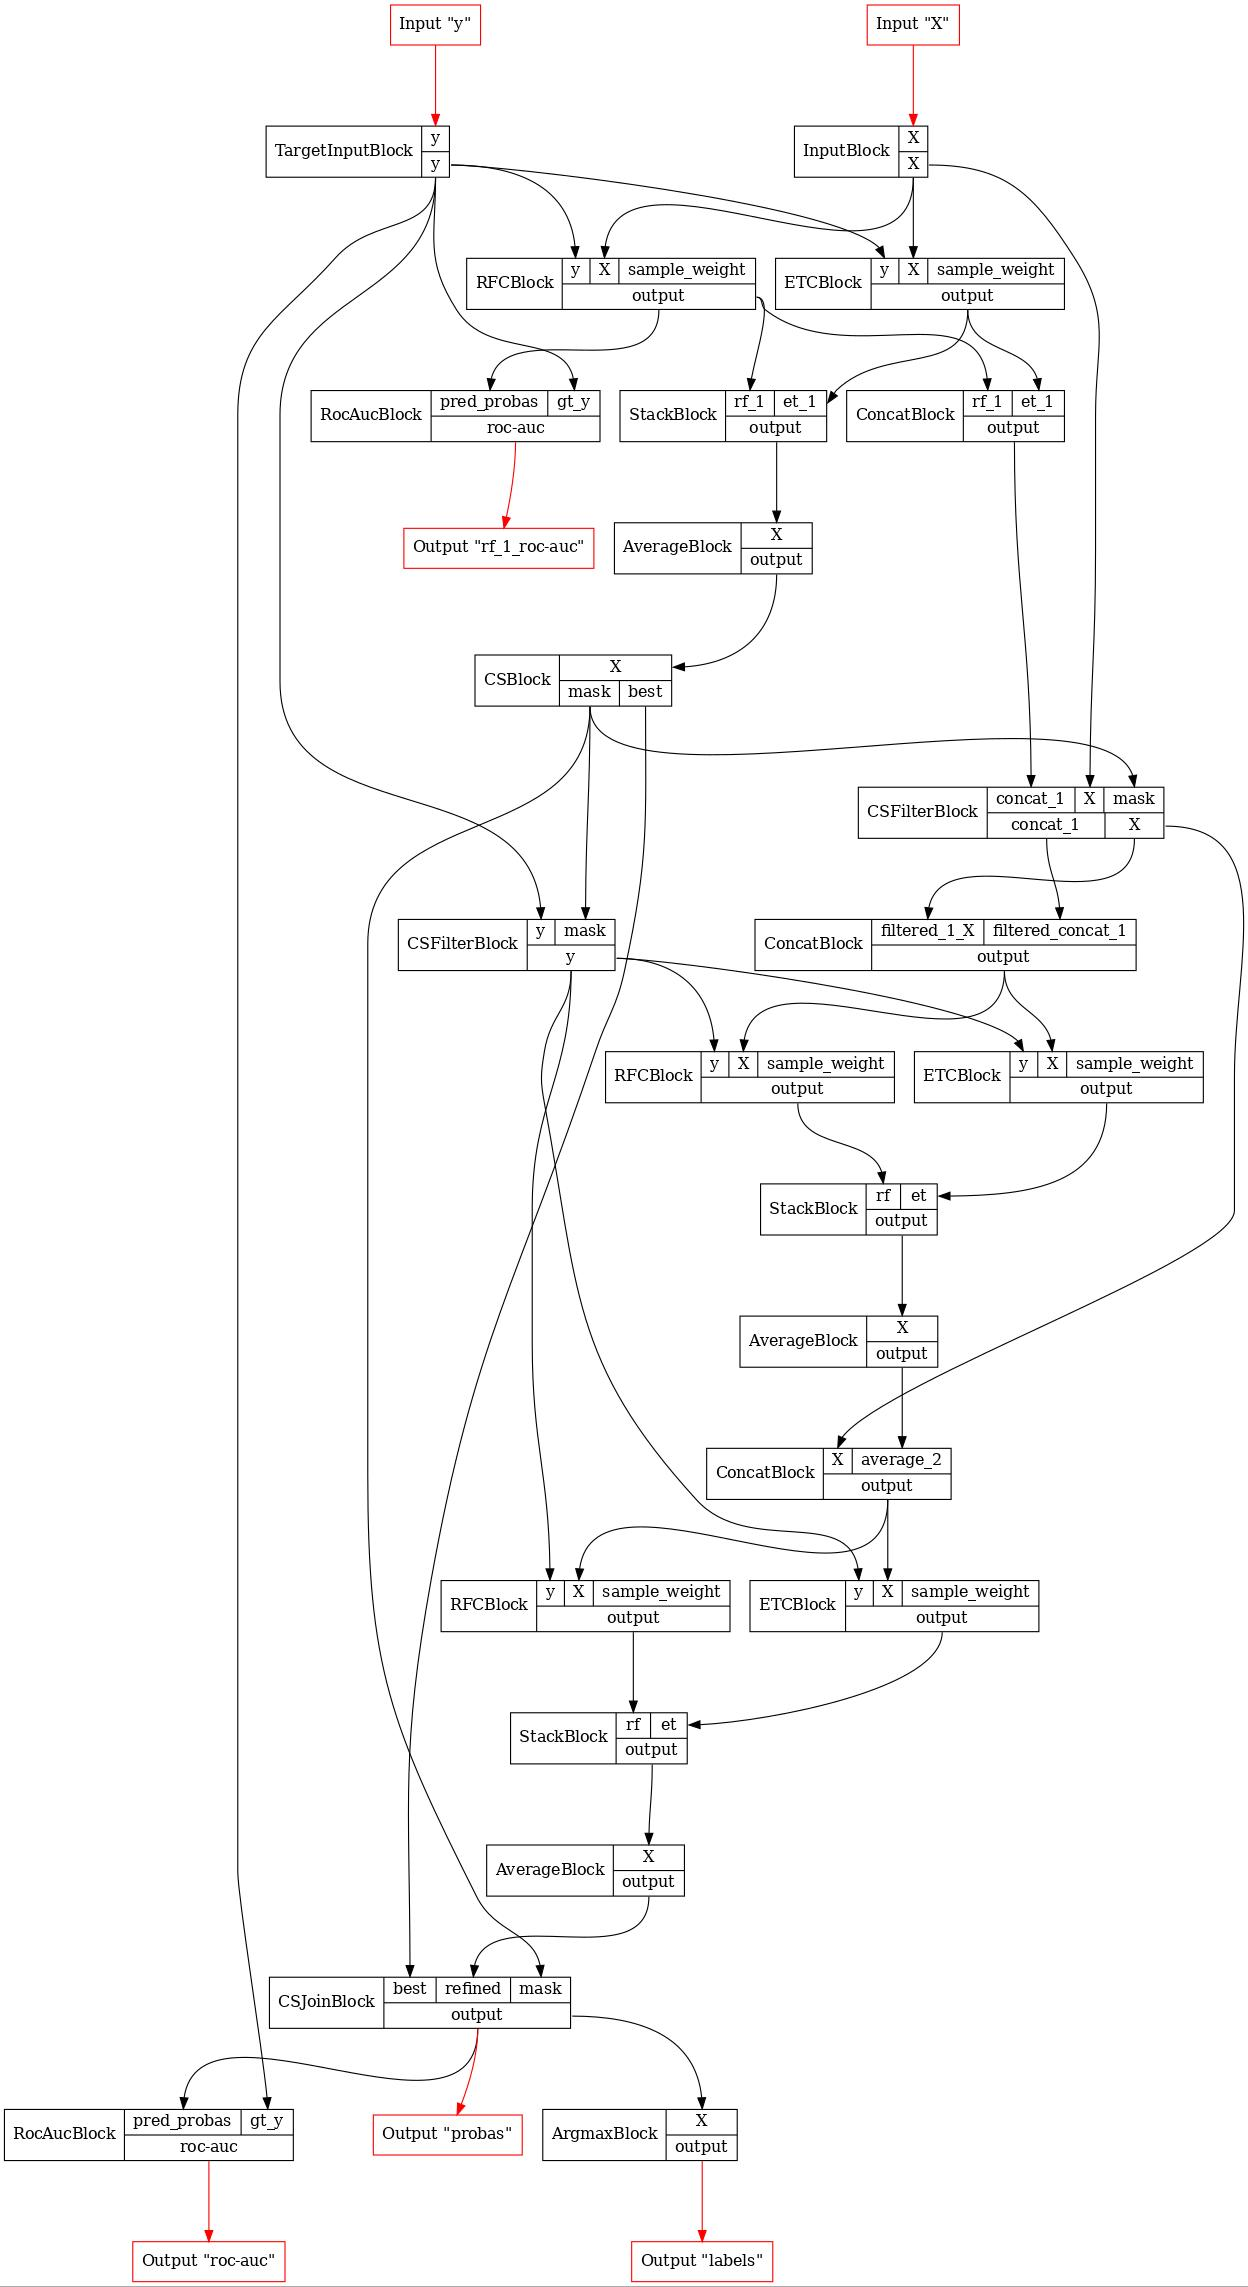

In [15]:
# helper function
def make_deep_forest_layer(b, **inputs):
    rf = b.RFC(n_estimators=n_estimators)(**inputs)
    et = b.ETC(n_estimators=n_estimators)(**inputs)
    stack = b.Stack(['rf', 'et'], axis=1)(rf=rf, et=et)
    average = b.Average(axis=1)(X=stack)
    return average

b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
rf_1 = b.RFC(n_estimators=n_estimators)(X=X, y=y)
et_1 = b.ETC(n_estimators=n_estimators)(X=X, y=y)
concat_1 = b.Concat(['rf_1', 'et_1'])(rf_1=rf_1, et_1=et_1)
stack_1 = b.Stack(['rf_1', 'et_1'], axis=1)(rf_1=rf_1, et_1=et_1)
average_1 = b.Average(axis=1)(X=stack_1)

# get confidence screening mask
cs_1 = b.CS(eps=0.95)(X=average_1)
# filter X and concatenated predictions samples by CS
filtered_1 = b.CSFilter(['concat_1', 'X'])(
    concat_1=concat_1,
    X=X,
    mask=cs_1['mask']
)
# y should be filtered separately since it is not used at the Transform stage
filtered_1_y = b.CSFilter(['y'])(y=y, mask=cs_1['mask'])
concat_all_1 = b.Concat(['filtered_1_X', 'filtered_concat_1'])(
    filtered_1_X=filtered_1['X'],
    filtered_concat_1=filtered_1['concat_1']
)

average_2 = make_deep_forest_layer(b, X=concat_all_1, y=filtered_1_y)
concat_2 = b.Concat(['X', 'average_2'])(X=filtered_1['X'], average_2=average_2)

average_3 = make_deep_forest_layer(b, X=concat_2, y=filtered_1_y)

# join confident samples with screened out ones
joined_3 = b.CSJoin()(
    best=cs_1['best'],
    refined=average_3,
    mask=cs_1['mask']
)

argmax_3 = b.Argmax(axis=1)(X=joined_3)

rf_1_roc_auc = b.RocAuc()(gt_y=y, pred_probas=rf_1)
roc_auc = b.RocAuc()(gt_y=y, pred_probas=joined_3)
pipeline = b.build(
    {'X': X, 'y': y},
    {'labels': argmax_3, 'probas': joined_3, 'rf_1_roc-auc': rf_1_roc_auc, 'roc-auc': roc_auc}
)
pipeline.set_random_state(random_state)
# let's draw the pipeline
# if a pipeline is too large, we can draw it
# from the top to the bottom
GraphvizPainter(figure_dpi=80, figure_rankdir='TB').from_pipeline(pipeline).render('deep_forest.jpeg')
display(Image(filename='deep_forest.jpeg'))

In [16]:
# let's run our pipeline
fit_executor = EXEC_CLS(
    pipeline,
    stage=Stage.FIT,
    inputs=['X', 'y'],
    outputs=['probas', 'rf_1_roc-auc', 'roc-auc'],
)
transform_executor = EXEC_CLS(
    pipeline,
    stage=Stage.TRANSFORM,
    inputs=['X'],
    outputs=['probas', 'labels']
)
train_X, test_X, train_y, test_y = get_plain_dataset()
fit_result = fit_executor({'X': train_X, 'y': train_y}).numpy()
train_result = transform_executor({'X': train_X}).numpy()
print("Fit probas == probas on train:", np.allclose(fit_result['probas'], train_result['probas']))
test_result = transform_executor({'X': test_X}).numpy()
print("Train ROC-AUC:", roc_auc_score(train_y, train_result['probas'][:, 1]))
print(
    "Train ROC-AUC calculated by fit_executor:",
    fit_result['roc-auc']
)
print(
    "Train ROC-AUC for RF_1:",
    fit_result['rf_1_roc-auc']
)
print("Test ROC-AUC:", roc_auc_score(test_y, test_result['probas'][:, 1]))

Fit probas == probas on train: True
Train ROC-AUC: 1.0
Train ROC-AUC calculated by fit_executor: 1.0
Train ROC-AUC for RF_1: 0.9892676767676768
Test ROC-AUC: 0.7797619047619047


Also the weighted modification of the confidence screening mechanism can be constructed.

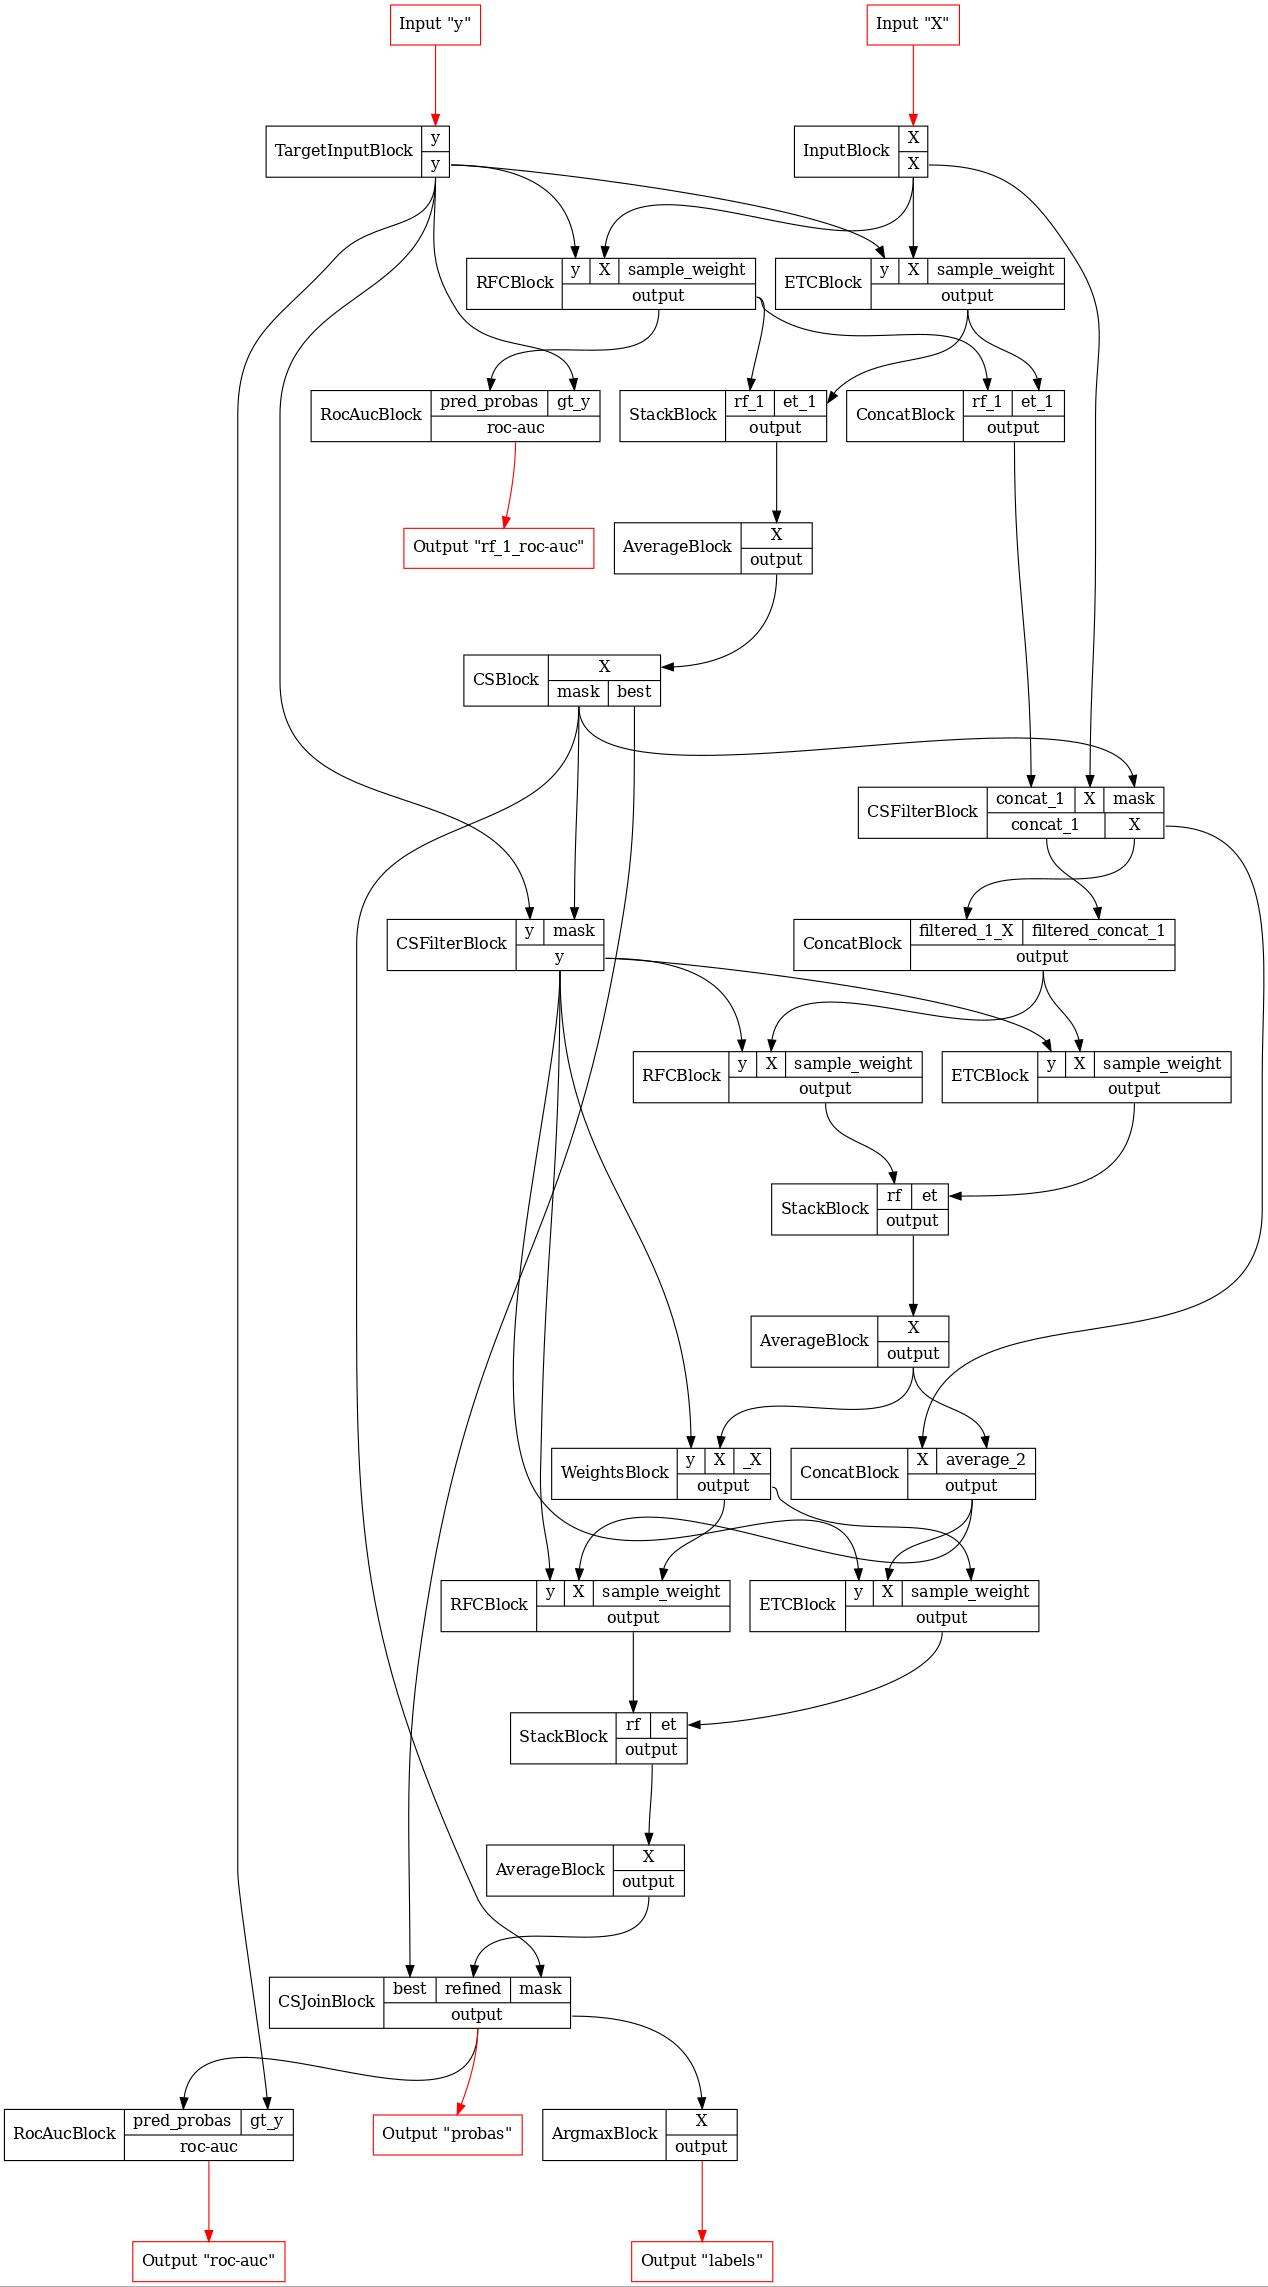

In [17]:
b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
rf_1 = b.RFC(n_estimators=n_estimators)(X=X, y=y)
et_1 = b.ETC(n_estimators=n_estimators)(X=X, y=y)
concat_1 = b.Concat(['rf_1', 'et_1'])(rf_1=rf_1, et_1=et_1)
stack_1 = b.Stack(['rf_1', 'et_1'], axis=1)(rf_1=rf_1, et_1=et_1)
average_1 = b.Average(axis=1)(X=stack_1)

# get confidence screening mask
cs_1 = b.CS(eps=0.95)(X=average_1)
# filter X and concatenated predictions samples by CS
filtered_1 = b.CSFilter(['concat_1', 'X'])(
    concat_1=concat_1,
    X=X,
    mask=cs_1['mask']
)
# y should be filtered separately since it is not used at the Transform stage
filtered_1_y = b.CSFilter(['y'])(y=y, mask=cs_1['mask'])
concat_all_1 = b.Concat(['filtered_1_X', 'filtered_concat_1'])(
    filtered_1_X=filtered_1['X'],
    filtered_concat_1=filtered_1['concat_1']
)

average_2 = make_deep_forest_layer(b, X=concat_all_1, y=filtered_1_y)
concat_2 = b.Concat(['X', 'average_2'])(X=filtered_1['X'], average_2=average_2)

sample_weight_2 = b.new(WeightsBlock, ord=2)(X=average_2, y=filtered_1_y)

average_3 = make_deep_forest_layer(b, X=concat_2, y=filtered_1_y, sample_weight=sample_weight_2)

# join confident samples with screened out ones
joined_3 = b.CSJoin()(
    best=cs_1['best'],
    refined=average_3,
    mask=cs_1['mask']
)

argmax_3 = b.Argmax(axis=1)(X=joined_3)

rf_1_roc_auc = b.RocAuc()(gt_y=y, pred_probas=rf_1)
roc_auc = b.RocAuc()(gt_y=y, pred_probas=joined_3)
pipeline = b.build(
    {'X': X, 'y': y},
    {'labels': argmax_3, 'probas': joined_3, 'rf_1_roc-auc': rf_1_roc_auc, 'roc-auc': roc_auc}
)
pipeline.set_random_state(random_state)
GraphvizPainter(figure_dpi=80, figure_rankdir='TB').from_pipeline(pipeline).render('deep_forest.jpeg')
display(Image(filename='deep_forest.jpeg'))

In [18]:
# let's run our pipeline
fit_executor = EXEC_CLS(
    pipeline,
    stage=Stage.FIT,
    inputs=['X', 'y'],
    outputs=['probas', 'rf_1_roc-auc', 'roc-auc'],
)
transform_executor = EXEC_CLS(
    pipeline,
    stage=Stage.TRANSFORM,
    inputs=['X'],
    outputs=['probas', 'labels']
)
train_X, test_X, train_y, test_y = get_plain_dataset()
fit_result = fit_executor({'X': train_X, 'y': train_y}).numpy()
train_result = transform_executor({'X': train_X}).numpy()
print("Fit probas == probas on train:", np.allclose(fit_result['probas'], train_result['probas']))
test_result = transform_executor({'X': test_X}).numpy()
print("Train ROC-AUC:", roc_auc_score(train_y, train_result['probas'][:, 1]))
print(
    "Train ROC-AUC calculated by fit_executor:",
    fit_result['roc-auc']
)
print(
    "Train ROC-AUC for RF_1:",
    fit_result['rf_1_roc-auc']
)
print("Test ROC-AUC:", roc_auc_score(test_y, test_result['probas'][:, 1]))

Fit probas == probas on train: True
Train ROC-AUC: 0.7386363636363636
Train ROC-AUC calculated by fit_executor: 0.7386363636363636
Train ROC-AUC for RF_1: 0.9892676767676768
Test ROC-AUC: 0.5833333333333334
